In [3]:
import pandas as pd


#data = pd.read_csv('../full_dataset.csv')
#data.drop('date', axis=1, inplace=True)

data = pd.read_csv('sampled_dataset.csv')

data.head()

,production,latitude,longitude,vmp,imp,voc,isc,p_per_m2,p_max,panel_area,...,wind_speed_10m_std,wind_speed_10m_min,wind_speed_10m_q1,wind_speed_10m_q2,wind_speed_10m_q3,wind_speed_10m_max,building_id,day,month,year
0,0.8,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.903114,1.3,1.900,3.00,3.450,4.1,1,1,1,2019
1,16.9,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.969186,0.9,2.975,3.50,3.825,4.8,1,2,1,2019
2,1.4,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.306945,0.4,1.100,1.20,1.400,1.9,1,3,1,2019
3,6.6,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.491844,0.4,0.800,1.20,1.725,2.1,1,4,1,2019
4,0.3,48.575437,7.768668,27.3,7.7,33.3,8.17,143.0,210,1.72,...,0.527737,1.6,2.275,2.85,3.100,3.4,1,5,1,2019


In [82]:
data_train = data[data['building_id'] != 8]
data_test = data[data['building_id'] == 8]

data_train.shape, data_test.shape

((1919, 164), (250, 164))

In [83]:
target_column = 'production'

x_train = data_train.drop(target_column, axis=1)
y_train = data_train[target_column].values.reshape(-1, 1)

x_test = data_test.drop(target_column, axis=1)
y_test = data_test[target_column].values.reshape(-1, 1)

In [84]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [85]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(x_train)

x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [86]:
def get_windows(x, y, window_size):
    x_windows, y_windows = [], []

    for i in range(len(x) - window_size):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        x_window = np.hstack((x_window, y_window))

        x_windows.append(x_window)
        y_windows.append(y[i+window_size])

    return np.array(x_windows), np.array(y_windows)

In [87]:
x_train_windows, y_train_windows = get_windows(x_train_scaled, y_train, 10)
x_test_windows, y_test_windows = get_windows(x_test_scaled, y_test, 10)

In [88]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import tensorflow as tf
tf.random.set_seed(42)

In [89]:
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(
        x_train_windows.shape[1:]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),

    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

model.summary()

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                  │ (None, 10, 128)        │       150,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,649 (795.50 KB)

 Trainable params: 203,649 (795.50 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
import time
import logging
from codecarbon import EmissionsTracker


tracker = EmissionsTracker(
    project_name="3CABTP",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="lstm.csv",
    output_dir='../emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon WARNING @ 09:15:49] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 09:15:49] [setup] RAM Tracking...
[codecarbon INFO @ 09:15:49] [setup] GPU Tracking...
[codecarbon INFO @ 09:15:49] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:15:49] [setup] CPU Tracking...
[codecarbon WARNING @ 09:15:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:15:51] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz
[codecarbon INFO @ 09:15:51] >>> Tracker's metadata:
[codecarbon INFO @ 09:15:51]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 09:15:51]   Python version: 3.10.11
[codecarbon INFO @ 09:15:51]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 09:15:51]   Available RAM : 15.767 GB
[codecarbon INFO @ 09:15:51]   CPU count: 12
[codecarbon INFO @ 09:15:51]   CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz
[codecarbon INFO @ 09:15:51]   GPU count: 1
[codecarbon I

In [91]:
def start_training():
    start_time = time.time()
    history = model.fit(x=x_train_windows,
                        y=y_train_windows,
                        epochs=300,
                        batch_size=128,
                        validation_split=0.2,
                        shuffle=False)
    training_duration = time.time() - start_time

    return history, training_duration

In [92]:
tracker.start()
try:
    history, training_duration = start_training()
finally:
    tracker.stop()

Epoch 1/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 32.8223 - val_loss: 21.2887
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 29.6036 - val_loss: 17.8548
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 27.0289 - val_loss: 15.3652
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 25.0485 - val_loss: 13.7940
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 23.7174 - val_loss: 13.0400
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 22.7717 - val_loss: 12.7862
Epoch 7/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 22.1418 - val_loss: 11.2485
Epoch 8/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.1442 - val_loss: 11.2113
Epoch 9/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.1163 - val_loss: 11.2610
Epoch 10/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.9785 - val_loss: 10.0171
Epoch 11/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 19.2919 - val_loss: 10.2868
Epoch 12/300
12/12 ━━━━━━━━━━━

[codecarbon INFO @ 09:16:01] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.912727355957031 W
[codecarbon INFO @ 09:16:01] Energy consumed for all GPUs : 0.000058 kWh. Total GPU Power : 20.670012418120617 W
[codecarbon INFO @ 09:16:01] Energy consumed for all CPUs : 0.000063 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 09:16:01] 0.000137 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 14.3018 - val_loss: 8.3345
Epoch 29/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 13.9369 - val_loss: 7.7367
Epoch 30/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13.4106 - val_loss: 7.8019
Epoch 31/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 13.4588 - val_loss: 8.5703
Epoch 32/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13.3946 - val_loss: 8.1048
Epoch 33/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13.0439 - val_loss: 7.6969
Epoch 34/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12.5974 - val_loss: 7.4918
Epoch 35/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12.3121 - val_loss: 7.0621
Epoch 36/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12.1655 - val_loss: 7.2229
Epoch 37/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11.9748 - val_loss: 7.4253
Epoch 38/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11.9056 - val_loss: 7.2854
Epoch 39/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17

[codecarbon INFO @ 09:16:11] Energy consumed for RAM : 0.000033 kWh. RAM Power : 5.912727355957031 W
[codecarbon INFO @ 09:16:11] Energy consumed for all GPUs : 0.000089 kWh. Total GPU Power : 11.326945692601436 W
[codecarbon INFO @ 09:16:11] Energy consumed for all CPUs : 0.000125 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 09:16:11] 0.000247 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.4849 - val_loss: 6.4150
Epoch 72/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.8208 - val_loss: 5.8349
Epoch 73/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.1548 - val_loss: 5.8735
Epoch 74/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9.0119 - val_loss: 5.8639
Epoch 75/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.8143 - val_loss: 5.9015
Epoch 76/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.7100 - val_loss: 5.9718
Epoch 77/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.6865 - val_loss: 5.4575
Epoch 78/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.4196 - val_loss: 5.3586
Epoch 79/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.4240 - val_loss: 5.2056
Epoch 80/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.5452 - val_loss: 5.6685
Epoch 81/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.4584 - val_loss: 5.5233
Epoch 82/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - l

[codecarbon INFO @ 09:16:21] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.912727355957031 W
[codecarbon INFO @ 09:16:21] Energy consumed for all GPUs : 0.000114 kWh. Total GPU Power : 8.801569214412106 W
[codecarbon INFO @ 09:16:21] Energy consumed for all CPUs : 0.000188 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 09:16:21] 0.000351 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.9637 - val_loss: 5.5956
Epoch 116/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.6206 - val_loss: 5.3418
Epoch 117/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.3056 - val_loss: 5.8145
Epoch 118/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.3067 - val_loss: 5.2331
Epoch 119/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.8499 - val_loss: 5.2017
Epoch 120/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.1416 - val_loss: 5.2720
Epoch 121/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.1558 - val_loss: 5.1082
Epoch 122/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.2230 - val_loss: 6.0416
Epoch 123/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.3115 - val_loss: 5.2204
Epoch 124/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.9414 - val_loss: 5.1500
Epoch 125/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.7234 - val_loss: 5.5495
Epoch 126/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18

[codecarbon INFO @ 09:16:31] Energy consumed for RAM : 0.000066 kWh. RAM Power : 5.912727355957031 W
[codecarbon INFO @ 09:16:31] Energy consumed for all GPUs : 0.000138 kWh. Total GPU Power : 8.707704412050019 W
[codecarbon INFO @ 09:16:31] Energy consumed for all CPUs : 0.000250 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 09:16:31] 0.000454 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.4462 - val_loss: 5.2632
Epoch 160/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9528 - val_loss: 5.1002
Epoch 161/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.8390 - val_loss: 5.4186
Epoch 162/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.8648 - val_loss: 5.1862
Epoch 163/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 6.2660 - val_loss: 5.5190
Epoch 164/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.2273 - val_loss: 5.2445
Epoch 165/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.3160 - val_loss: 5.5344
Epoch 166/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.2740 - val_loss: 5.5097
Epoch 167/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.1294 - val_loss: 5.3234
Epoch 168/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9101 - val_loss: 5.6439
Epoch 169/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.9691 - val_loss: 5.1892
Epoch 170/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17

[codecarbon INFO @ 09:16:41] Energy consumed for RAM : 0.000082 kWh. RAM Power : 5.912727355957031 W
[codecarbon INFO @ 09:16:41] Energy consumed for all GPUs : 0.000163 kWh. Total GPU Power : 8.944978109660356 W
[codecarbon INFO @ 09:16:41] Energy consumed for all CPUs : 0.000313 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 09:16:41] 0.000558 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.2672 - val_loss: 5.3003
Epoch 203/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.3505 - val_loss: 5.0431
Epoch 204/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.2866 - val_loss: 5.3019
Epoch 205/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.1052 - val_loss: 5.1118
Epoch 206/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 5.1227 - val_loss: 5.6508
Epoch 207/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 5.1460 - val_loss: 4.8367
Epoch 208/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.2013 - val_loss: 4.8418
Epoch 209/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 5.2823 - val_loss: 5.2865
Epoch 210/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.1091 - val_loss: 5.3592
Epoch 211/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.9950 - val_loss: 5.0958
Epoch 212/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5.0872 - val_loss: 5.3128
Epoch 213/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20

[codecarbon INFO @ 09:16:51] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.912727355957031 W


 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0539

[codecarbon INFO @ 09:16:51] Energy consumed for all GPUs : 0.000217 kWh. Total GPU Power : 19.711846641406073 W
[codecarbon INFO @ 09:16:51] Energy consumed for all CPUs : 0.000376 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 09:16:51] 0.000691 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.4135 - val_loss: 4.8965
Epoch 239/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.6398 - val_loss: 5.2973
Epoch 240/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 5.0091 - val_loss: 5.0398
Epoch 241/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.7855 - val_loss: 4.8041
Epoch 242/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.6262 - val_loss: 5.4490
Epoch 243/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.7132 - val_loss: 5.0044
Epoch 244/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.6659 - val_loss: 5.4017
Epoch 245/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.9834 - val_loss: 4.8951
Epoch 246/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.9560 - val_loss: 5.6498
Epoch 247/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.9882 - val_loss: 4.8674
Epoch 248/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.6767 - val_loss: 5.1964
Epoch 249/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20

[codecarbon INFO @ 09:17:01] Energy consumed for RAM : 0.000115 kWh. RAM Power : 5.912727355957031 W
[codecarbon INFO @ 09:17:01] Energy consumed for all GPUs : 0.000257 kWh. Total GPU Power : 14.101687049142358 W
[codecarbon INFO @ 09:17:01] Energy consumed for all CPUs : 0.000438 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 09:17:01] 0.000809 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3131 - val_loss: 5.2306
Epoch 280/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.1305 - val_loss: 5.2112
Epoch 281/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2677 - val_loss: 5.3567
Epoch 282/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3027 - val_loss: 5.4571
Epoch 283/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6773 - val_loss: 5.6068
Epoch 284/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0412 - val_loss: 5.5930
Epoch 285/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.6764 - val_loss: 5.4851
Epoch 286/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.4212 - val_loss: 5.2082
Epoch 287/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1703 - val_loss: 5.2957
Epoch 288/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.3734 - val_loss: 5.1856
Epoch 289/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.4766 - val_loss: 5.4724
Epoch 290/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18

[codecarbon INFO @ 09:17:06] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.912727355957031 W
[codecarbon INFO @ 09:17:06] Energy consumed for all GPUs : 0.000270 kWh. Total GPU Power : 9.027889949181823 W
[codecarbon INFO @ 09:17:06] Energy consumed for all CPUs : 0.000471 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 09:17:06] 0.000864 kWh of electricity used since the beginning.
c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\codecarbon\output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])
[codecarbon WARNING @ 09:17:06] graceful shutdown. Exceptions:
[codecarbon WARNING @ 09:17:06] <class 'Exception'>
Traceback (most recent cal

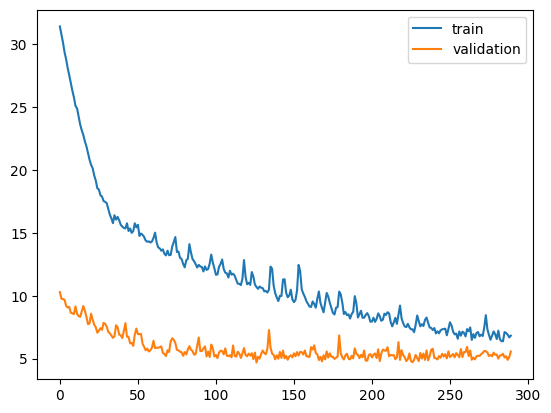

In [93]:
import matplotlib.pyplot as plt

start = 10
plt.plot(history.history['loss'][start:], label='train')
plt.plot(history.history['val_loss'][start:], label='validation')

plt.legend()
plt.show()

In [94]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape
    }

In [95]:
y_pred_train = model.predict(x_train_windows)
y_pred_test = model.predict(x_test_windows)

print(evaluate_model(y_train_windows, y_pred_train))
print(evaluate_model(y_test_windows, y_pred_test))

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
{'mse': 182.44024737077174, 'r2': 0.9472140556666357, 'mae': 5.019600289083141, 'mape': 56238841738282.77}
{'mse': 7.16224793329054, 'r2': 0.9729243097645094, 'mae': 1.9072454711546498, 'mape': 0.13503354800602674}


In [96]:
x_test_windows.shape

(240, 10, 164)

In [97]:
baseline_predictions = []

for x in x_test_windows:
    baseline_predictions.append(x[-1][-1])

baseline_predictions = np.array(baseline_predictions).reshape(-1, 1)
print(evaluate_model(y_test_windows, baseline_predictions))

{'mse': 257.8424166666667, 'r2': 0.025269514786318892, 'mae': 10.981666666666666, 'mape': 1.2531154751810272}


In [98]:
# model.save('../models/lstm_model.keras')

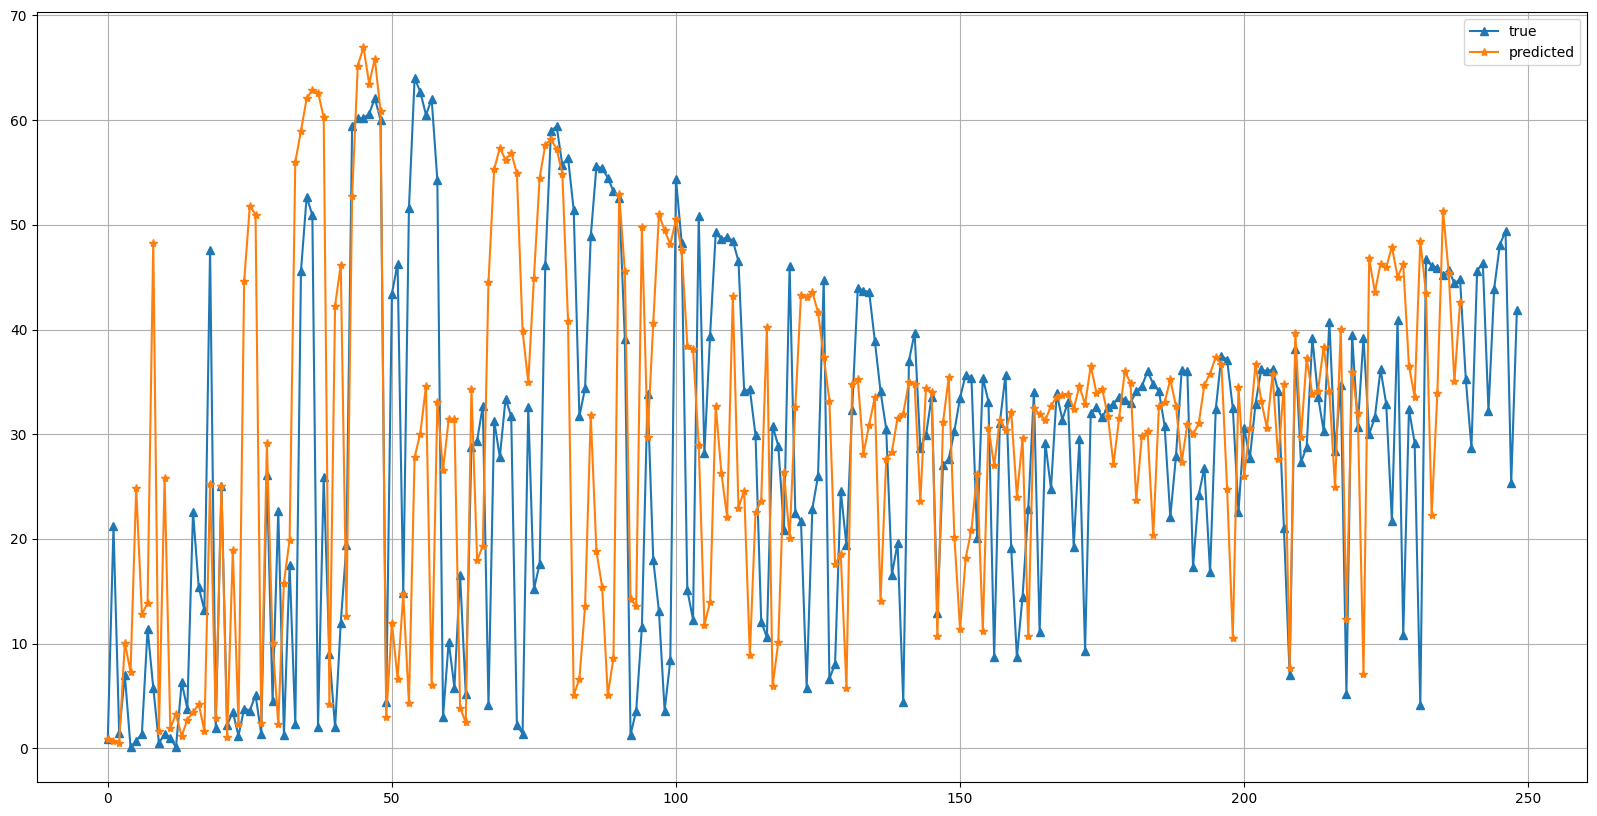

In [99]:
plt.figure(figsize=(20, 10))

start = 0
end = -1

plt.plot(y_test[start:end], '-^', label='true')
plt.plot(y_pred_test[start:end], '-*', label='predicted')

plt.legend()
plt.grid(True)
plt.show()

In [100]:
#Hyperparameter optimisation

import numpy as np
import random

# Exemple de fonction d'évaluation
# Cette fonction doit être remplacée par le processus d'évaluation de votre modèle
def evaluate_score(hyperparameters):
    # Ici, vous évaluerez votre modèle en utilisant les hyperparamètres
    # et retournerez une métrique de performance, comme l'accuracy
    # Pour cet exemple, on retourne une valeur aléatoire (à remplacer)
    model = Sequential([
        LSTM(hyperparameters[0], activation=hyperparameters[1], input_shape=(
            x_train_windows.shape[1:]), return_sequences=True),
        Dropout(hyperparameters[2]),
        LSTM(hyperparameters[3], activation=hyperparameters[4], return_sequences=False),
        Dropout(hyperparameters[5]),
        Dense(hyperparameters[6], activation=hyperparameters[7]),

        Dense(1, activation='linear')
    ])

    optimizer = Adam(learning_rate=hyperparameters[8])
    model.compile(optimizer=optimizer, loss='mean_absolute_error')

    model.fit(x=x_train_windows,
              y=y_train_windows,
              epochs=hyperparameters[9],
              batch_size=hyperparameters[10],
              validation_split=0.2,
              shuffle=False)

    y_pred_test = model.predict(x_test_windows)

    print("y_true shape:", y_test_windows.shape)
    print("y_pred shape:", y_pred_test.shape)

    evaluation = evaluate_model(y_test_windows, y_pred_test)

    return evaluation['mse']

# Fonction pour convertir la représentation numérique en chaîne de caractères pour l'hyperparamètre catégoriel
def correct_hyperparameters_value(hyperparameters_value):
    corrected_hyperparameters_value = hyperparameters_value.copy()
    categories = ['tanh', 'relu', 'sigmoid', 'hard_sigmoid', 'linear']

    corrected_hyperparameters_value[0] = int(np.round(hyperparameters_value[0]))
    corrected_hyperparameters_value[1] = categories[int(hyperparameters_value[1])]
    corrected_hyperparameters_value[3] = int(np.round(hyperparameters_value[3]))
    corrected_hyperparameters_value[4] = categories[int(hyperparameters_value[4])]
    corrected_hyperparameters_value[6] = int(np.round(hyperparameters_value[6]))
    corrected_hyperparameters_value[7] = categories[int(hyperparameters_value[7])]
    corrected_hyperparameters_value[9] = int(np.round(hyperparameters_value[9]))
    corrected_hyperparameters_value[10] = int(np.round(hyperparameters_value[10]))
    print(corrected_hyperparameters_value)

    return corrected_hyperparameters_value

# PSO
class Particle:
    def __init__(self, bounds):
        self.position = np.array([random.uniform(bound[0], bound[1]) for bound in bounds])
        self.velocity = np.array([random.uniform(-1, 1) for _ in bounds])
        self.best_position = self.position.copy()
        self.best_score = -float('inf')

    def update_velocity(self, global_best_position):
        w = 0.5  # inertie
        c1 = 0.8  # cognition (particule)
        c2 = 0.9  # social (essaim)
        
        for i in range(len(self.velocity)):
            r1, r2 = random.random(), random.random()
            cognitive_velocity = c1 * r1 * (self.best_position[i] - self.position[i])
            social_velocity = c2 * r2 * (global_best_position[i] - self.position[i])
            self.velocity[i] = w * self.velocity[i] + cognitive_velocity + social_velocity

    def update_position(self, bounds):
        self.position += self.velocity
        # Appliquer les contraintes de l'espace de recherche
        for i in range(len(self.position)):
            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]
            elif self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]

def pso(num_particles, bounds, num_iterations):
    particles = [Particle(bounds) for _ in range(num_particles)]
    global_best_score = float('inf')
    global_best_position = None

    for _ in range(num_iterations):
        particles_count = 1
        for particle in particles:
            hyperparameters = correct_hyperparameters_value(particle.position.copy().tolist()) # Coorection des valeurs des hyperparamètres

            score = evaluate_score(hyperparameters)
            print("iteration : ", _, " / particle_count : ", particles_count)
            print("hyperparameters : ", hyperparameters)
            print("mse : ", score)

            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = particle.position.copy()

            if score < global_best_score:
                global_best_score = score
                global_best_position = particle.position.copy()
            
            particles_count += 1

        for particle in particles:
            particle.update_velocity(global_best_position)
            particle.update_position(bounds)
    
    return global_best_position, global_best_score

# Bounds de chaque hyperparamètre
bounds = [(16, 256),     # units LSTM 1
          (0, 4),        # activation LSTM 1
          (0, 1),        # rate dropout1
          (16, 256),     # units LSTM 2
          (0, 4),        # activation LSTM 2
          (0, 1),        # rate dropout 2
          (16, 256),     # units DENSE 1
          (0, 4),        # activation DENSE 1
          (0, 0.001),    # learning rate OPTIMIZER
          (200, 400),    # epoch number
          (32, 128)]     # batch size

num_particles = 5
num_iterations = 10

best_position, best_score = pso(num_particles, bounds, num_iterations)
converted_best_position = correct_hyperparameters_value(best_position.copy().tolist())
print(f"Meilleure position: {converted_best_position}, Meilleur score: {best_score}")

[18, 'relu', 0.8608364795308181, 102, 'relu', 0.01103669670943952, 186, 'sigmoid', 0.0007664715366558639, 35, 818]
Epoch 1/35


c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 428ms/step - loss: 39.8468 - val_loss: 25.0596
Epoch 2/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 39.3133 - val_loss: 24.5487
Epoch 3/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 38.7156 - val_loss: 23.9796
Epoch 4/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 38.1004 - val_loss: 23.3751
Epoch 5/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 37.4541 - val_loss: 22.7339
Epoch 6/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 36.8172 - val_loss: 22.0496
Epoch 7/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 36.0907 - val_loss: 21.3282
Epoch 8/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 35.4843 - val_loss: 20.6093
Epoch 9/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 34.9366 - val_loss: 19.9589
Epoch 10/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 34.4743 - val_loss: 19.3021
Epoch 11/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 34.0937 - val_loss: 18.6868
Epoch 12/35
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 33.7577 - val_

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 42.7330 - val_loss: 24.7667
Epoch 2/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 42.4549 - val_loss: 24.4750
Epoch 3/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 42.1851 - val_loss: 24.1765
Epoch 4/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 41.9081 - val_loss: 23.8652
Epoch 5/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 41.6339 - val_loss: 23.5367
Epoch 6/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 41.3490 - val_loss: 23.1797
Epoch 7/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 41.0492 - val_loss: 22.7988
Epoch 8/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 40.7536 - val_loss: 22.4270
Epoch 9/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 40.4591 - val_loss: 22.1004
Epoch 10/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 40.2033 - val_loss: 21.8274
Epoch 11/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 39.9986 - val_loss: 21.5793
Epoch 12/35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 39.80

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step - loss: 38.6609 - val_loss: 20.9474
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 35.1029 - val_loss: 17.4421
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 32.7454 - val_loss: 14.8687
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 31.2400 - val_loss: 13.9682
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 30.1993 - val_loss: 13.5849
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 29.7654 - val_loss: 13.5263
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 29.5700 - val_loss: 13.4188
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 29.4194 - val_loss: 13.2744
Epoch 9/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 29.2327 - val_loss: 13.1743
Epoch 10/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 29.0652 - val_loss: 13.0735
Epoch 11/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 28.8416 - val_loss: 12.9332
Epoch 12/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 28.5

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 34.5086 - val_loss: 22.7813
Epoch 2/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.3164 - val_loss: 19.4257
Epoch 3/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.9820 - val_loss: 17.9804
Epoch 4/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.0505 - val_loss: 17.3598
Epoch 5/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 27.6123 - val_loss: 16.9734
Epoch 6/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 27.3096 - val_loss: 16.6573
Epoch 7/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 27.0573 - val_loss: 16.3788
Epoch 8/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 26.8270 - val_loss: 16.1146
Epoch 9/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.6076 - val_loss: 15.8652
Epoch 10/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.4021 - val_loss: 15.6341
Epoch 11/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 26.2092 - val_loss: 15.4091
Epoch 12/27
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 43.3083 - val_loss: 25.0553
Epoch 2/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 43.1103 - val_loss: 24.8411
Epoch 3/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 42.8973 - val_loss: 24.5916
Epoch 4/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 42.6720 - val_loss: 24.2642
Epoch 5/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 42.3861 - val_loss: 23.8110
Epoch 6/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 42.0662 - val_loss: 23.1902
Epoch 7/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 41.7544 - val_loss: 22.3838
Epoch 8/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 41.4107 - val_loss: 21.4958
Epoch 9/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 41.1092 - val_loss: 20.7582
Epoch 10/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 40.8761 - val_loss: 20.2242
Epoch 11/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 40.6592 - val_loss: 19.8880
Epoch 12/26
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 40.4